# Task Description

- 올거나이즈 RAG-Evaluation-Dataset-Ko 데이터셋을 활용해서 RAG 시스템 구축하기
  - https://huggingface.co/datasets/allganize/RAG-Evaluation-Dataset-KO

- 사용자가 질문할 때, 5개의 도메인 중 하나를 선택해서 질문한다고 가정
  - finance, public, medical, law, commerce

- 사용자의 질문에 대한 답을 관련 문서에 기반해서 생성하기

## WorkFlow

- 도메인별 PDF 문서 로딩 및 전처리

- 문서 분할 (Chunking)
- KoE5 임베딩 및 Chroma 벡터스토어 생성
- Retriever로 유사 문서 검색 (Top-10)
- Re-ranker로 정확도 높은 문서 재정렬 (Top-6)
- Prompt 구성
- GPT-4o-mini로 정답 생성
- 결과 저장 및 평가


# Set Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 평가를 위한 패키지
!pip install mlflow
!pip install langchain
!pip install langchain-openai
!pip install langchain-anthropic
!pip install ragas

# vector store를 위한 패키지
!pip install langchain_chroma
#!pip install pypdf
!pip install pymupdf

# 데이터 분석 및 필요한 PDF 다운로드  
- 사용된 pdf만 다운로드 했습니다.
  - 총 63개 중 53개 사용

In [ ]:
import pandas as pd
df = pd.read_csv("hf://datasets/allganize/RAG-Evaluation-Dataset-KO/rag_evaluation_result.csv")
df.head(1)

# 필요한 column 파악: domain, question, target_answer, target_file_name

In [ ]:
# 어떤 문서가 필요한지 확인 및 다운로드
## document.csv 중에서, 위의 data의 target_file_name에 있는 pdf만 다운로드
### pdf 다운로드 안 되는 것들만 직접 다운로드
target_file_list = df['target_file_name'].unique()
url = "https://huggingface.co/datasets/allganize/RAG-Evaluation-Dataset-KO/resolve/main/documents.csv"

pdf_file_information = pd.read_csv(url)

url_domain_list=[]
for target in target_file_list:
    if target in pdf_file_information['file_name'].tolist():
        url = pdf_file_information[pdf_file_information['file_name']==target]['url'].iloc[0]
        domain = pdf_file_information[pdf_file_information['file_name']==target]['domain'].iloc[0]
        file_name = pdf_file_information[pdf_file_information['file_name']==target]['file_name'].iloc[0]
    else: # pdf 이름 달라서 예외
        url = "https://www.moe.go.kr/sub/infoRenew.do?page=72760&m=031101&s=moe"
        domain  = "public"
        file_name = '(보도자료)2024년+교육부+주요정책+추진계획+발표_보도자료.pdf'
    url_domain_list.append((url,domain,file_name))
url_domain_list

In [ ]:
import requests
import os


data = url_domain_list
base_dir = "/content/drive/MyDrive/rag_pdf_files"

for url, domain, file_name in data:
    if url.lower().endswith(".pdf"):
        # PDF인 경우 다운로드
        domain_dir = os.path.join(base_dir, domain)
        os.makedirs(domain_dir, exist_ok=True)
        save_path = os.path.join(domain_dir, file_name)

        try:
            response = requests.get(url)
            if response.status_code == 200:
                with open(save_path, "wb") as f:
                    f.write(response.content)
                print(f"✅ 다운로드 완료: {save_path}")
            else:
                print(f"❌ 다운로드 실패: {url} (상태 코드 {response.status_code})")
        except Exception as e:
            print(f"❌ 오류 발생: {url} ({e})")
    else:
        # PDF 아닌 경우 파일명만 출력
        print(f"📄 PDF 아님, 파일명 출력: {file_name}")

# html 이거나 다운로드 실패한건 직접 추가

# RAG 시스템 구축

- 프레임워크: LangChain

## PDF로부터 Domain 별 vector DB & Retriever 만들기
- PDF 로더 : PyPDFLoader -> PyMuPDFLoader
  - 한국어에 강하고 처리 속도 빠름
  - 특수문자 인코딩에 강함
  - 파싱 및 page 별 분할: loader.load_and_split()
- 청킹: MarkdownTextSplitter, #RecursiveCharacterTextSplitter(그냥 길이 기준 분할)
  - 마크다운 문법 인식 및 문서 구조를 인식하여 자연스럽게 분할
- vector store: Chroma
- embedding model: KoE5
  - https://huggingface.co/nlpai-lab/KoE5

### Retriever
- search_type: 벡터 유사도 기반
- top_k: 10개
  - 몇개 찾을건지 k와 chunk 사이즈에 따른 실험을 통해 정해야됨
- 참고: search_type 설정에 bm25가 없어서, 하이브리드 서치 하려면 직접 bm25 구현해서 가중치 주거나 혹은, 다른 솔루션(Elastic search 등) 사용

### Reranker
- reranker : Dongjin-kr/ko-reranker
  - https://huggingface.co/Dongjin-kr/ko-reranker
- reranked_k : 5개




In [ ]:
import glob
from tqdm import tqdm
from langchain_community.document_loaders import PyMuPDFLoader#PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter,MarkdownTextSplitter
from langchain_chroma import Chroma
from langchain.embeddings import HuggingFaceEmbeddings

# 도메인 별로 vectore store 만들기
domains = ['finance', 'public', 'medical', 'law', 'commerce']
retrievers = {}  # 도메인별 retriever 저장용

# 임베딩 모델 지정
from langchain_community.embeddings import HuggingFaceEmbeddings
embedding_model = HuggingFaceEmbeddings(model_name="nlpai-lab/KoE5")

# 텍스트 분할기 정의
#text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200, add_start_index=True)
text_splitter = MarkdownTextSplitter(chunk_size=800, chunk_overlap=200, add_start_index=True)

# 도메인별로 벡터스토어 생성
for domain in domains:

    # PDF 경로 로딩
    pdf_paths = glob.glob(f"/content/drive/MyDrive/rag_pdf_files/{domain}/*.pdf")
    all_docs = []

    for path in tqdm(pdf_paths, desc=f"Loading {domain} PDFs"):
        #loader = PyPDFLoader(path)
        loader = PyMuPDFLoader(path)
        docs = loader.load_and_split() # PDF를 페이지별 Document 리스트로 분리
        all_docs.extend(docs)

    if not all_docs:
        print(f"⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️  {domain}⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️")
        continue

    # 텍스트 청크 분할
    all_splits = text_splitter.split_documents(all_docs)

    # vectorstore 생성:
    vectorstore = Chroma.from_documents( # all_splits 안의 작은 텍스트 청크들을 벡터 임베딩 처리해서 벡터 DB(벡터스토어)를 만드는 함수
        documents=all_splits,
        embedding=embedding_model,
        collection_name=f"rag_{domain}"  # 도메인별로 컬렉션 구분
    )
    retriever = vectorstore.as_retriever( # vectorstore를 실제 검색용 객체인 Retriever로 변환
        search_type="similarity",
        search_kwargs={"k": 10}
    )

    retrievers[domain] = retriever

In [ ]:
all_splits[-1]

In [ ]:
############# re-ranker 정의
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_path = "Dongjin-kr/ko-reranker"
tokenizer = AutoTokenizer.from_pretrained(model_path)
re_ranker = AutoModelForSequenceClassification.from_pretrained(model_path)
re_ranker.eval() # 학습용 레이어, gradient 계산 비활성화

def exp_normalize(x):
    b = x.max()
    y = np.exp(x - b)
    return y / y.sum()

def rerank_ko_reranker(query, docs, top_k=6):
    pairs = [[query, doc.page_content] for doc in docs]

    with torch.no_grad():
        inputs = tokenizer(pairs, padding=True, return_tensors='pt',
                           truncation=True, max_length=512 # 최대 길이 512넘으면 자름
                           )
        logits = re_ranker(**inputs).logits.view(-1).float() # 각 (q, 관련 텍스트) 에 대해서 점수 뽑는 거임.
        scores = exp_normalize(logits.numpy())

    ranked = sorted(zip(docs, scores), key=lambda x: x[1], reverse=True)
    return [doc for doc, _ in ranked[:top_k]]

## 답변 생성하기
- LLM : Chatgpt-4o-mini
- 테스트 데이터셋: 도메인 당 10개
- 생성 prompt : rlm/ rag-prompt

In [ ]:
from langchain import hub
from langchain_openai import ChatOpenAI
import numpy as np
import os

# 최종 답변생성하는 llm  -> #########제출전 key 지우기########
os.environ["OPENAI_API_KEY"] = ""
llm = ChatOpenAI(model="gpt-4o-mini")

test_n = 10
prompt = hub.pull("rlm/rag-prompt")
'''
template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"
'''
df = pd.read_csv("hf://datasets/allganize/RAG-Evaluation-Dataset-KO/rag_evaluation_result.csv")

domains = ['finance', 'public', 'medical', 'law', 'commerce']

for domain in domains:

    # retriever
    retriever = retrievers[domain]

    # questions
    questions = df[df['domain']==domain]['question'][:test_n].tolist()

    # 답변생성
    results = []

    for q in tqdm(questions):
        retrieved_docs = retriever.invoke(q) # 탐색
        reranked_docs = rerank_ko_reranker(q, retrieved_docs, top_k=6)

        formatted_context = "\n\n".join(doc.page_content for doc in reranked_docs) # 탐색 결과 이어 붙이기
        #print(formatted_context)

        # prompt에 context, question 넣기
        prompt_result = prompt.invoke({"context": formatted_context, "question": q})
        #print(prompt_result)

        # llm에 들어가는 HumanMessage
        messages = prompt_result.to_messages()
        #print(messages)
        #break

        answer = llm.invoke(messages)

        results.append({
              "question": q,
              "answer": answer.content,
              "retrieved_context": [i.page_content for i in reranked_docs]
        })

    # 결과를 CSV로 저장
    result  = pd.DataFrame(results)
    result.to_csv("/content/drive/MyDrive/rag_pdf_files/{}_rag_answers_with_context.csv".format(domain), index=False)


In [ ]:
result_law_ = pd.read_csv("/content/drive/MyDrive/rag_pdf_files/law_rag_answers_with_context.csv")
result_law_

In [ ]:
sample_law_1 = result_law_.iloc[3]
print("#############qusetion")
print(sample_law_1['question'])
print(" ")
print("############검색결과")
print(sample_law_1['retrieved_context'])
print(" ")
print("###########생성된 답변")
print(sample_law_1['answer'])
print(" ")
print("###########target 답변")
df[df['domain']=='law']['target_answer'][:test_n].tolist()[3]

# 평가

## 1.ragas score:
- https://docs.ragas.io/en/v0.1.21/concepts/metrics/index.html
- 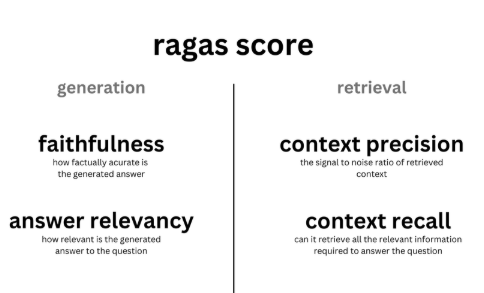

default llm: gpt-3.5-turbo

- answer_relevancy, # 생성 평가: 질문과 답변의 관계정도
- faithfulness, # 생성 평가: 답변이 얼마나 Context에 근거한 정확한 답변인지
- context_recall, # 검색 평가: 정답을 n개의 문장으로 쪼개고, 각 문장이 retrieved context에 있는지 확인
- context_precision # 검색 평가: 검색된 k개의 context 중에 정답(ground truth 만드는 데 도움이 되는지 확인) 비율

## 2.allganize 자동평가:
- https://huggingface.co/datasets/allganize/RAG-Evaluation-Dataset-KO 의 Auto Evaluate Colab 참조
- 총 4개의 LLM Eval을 사용하여 평가한 후, voting 하여 "O" 혹은 "X"를 결정했습니다.
- llm_evaluate() 함수
  - 밑의 4가지 평가 결과를 종합
  - O (정답) / X (오답)으로 통합 판단
  1. TonicAI : answer_similarity (threshold=4)
    - OpenAI 모델을 사용하여 생성된 답변과 기준 정답의 유사도를 0~5 점수로 출력
    - 평가 모델은 openai:/gpt-4o-mini 사용
  2. MLflow : answer_similarity/v1/score (threshold=4)
    - 0~5 스칼라 출력인듯
    - 평가 모델은 openai:/gpt-4o-mini 사용
  3. MLflow : answer_correctness/v1/score (threshold=4)
    - 0~5 스칼라 출력 인듯
    - 평가 모델은 openai:/gpt-4o-mini 사용
  4. Allganize Eval : answer_correctness/claude3-opus
    - 생성된 답변의 정확성을 기준 답변과 비교하여 검증
      - 맞으면 1, 틀리면 0 출력
    - 평가 모델은 "claude-3-opus-20240229" 사용



In [ ]:
def llm_evaluate(question: list, generated_answer: list, target_answer: list) -> list:
    """
    여러 평가 방법을 사용하여 LLM이 생성한 답변을 종합 평가합니다.

    Args:
        question (list): 질문 목록.
        generated_answer (list): 모델이 생성한 답변 목록.
        target_answer (list): 기준 답변 목록.

    Returns:
        list: 각 답변에 대한 최종 평가 결과 ('O'는 정답, 'X'는 오답).
    """
    tonic_answer_similarity = tonic_validate(question, generated_answer, target_answer, model="gpt-4o-mini")
    mlflow_answer_similarity, mlflow_answer_correctness = mlflow_eval(question, generated_answer, target_answer, model="openai:/gpt-4o-mini")
    allganize_answer_correctness = allganize_eval(question, generated_answer, target_answer, model="claude-3-opus-20240229")

    def get_evaluation_result(score: int) -> str:
      if score >= 4:
          return "O"
      else:
          return "X"
    def most_frequent_element(result: list) -> str:
        """
        리스트에서 가장 빈번하게 등장하는 요소를 반환하며, 특정 값에 우선순위를 둡니다.

        Args:
            result (list): 평가 결과 목록.

        Returns:
            str: 가장 빈번한 결과 ("O"는 정답, "X"는 오답).
        """
        count = Counter(result)
        priority = ["X", "O"]  # 'X'와 'O'에 대한 우선순위 정의

        most_common = count.most_common()
        for element in priority:
            if element in count and count[element] == most_common[0][1]:
                return element

    e2e_result = []
    for i in range(len(tonic_answer_similarity)):
        tonic_answer_similarity_ox = get_evaluation_result(tonic_answer_similarity[i])
        mlflow_answer_similarity_ox = get_evaluation_result(mlflow_answer_similarity[i])
        mlflow_answer_correctness_ox = get_evaluation_result(mlflow_answer_correctness[i])
        allganize_answer_correctness_ox = "O" if allganize_answer_correctness[i] == 1 else "X"

        # 가장 빈번한 평가 결과를 사용하여 종합 결과 결정
        e2e_result.append(
            most_frequent_element(
                [
                    tonic_answer_similarity_ox,
                    mlflow_answer_similarity_ox,
                    mlflow_answer_correctness_ox,
                    allganize_answer_correctness_ox,
                ]
            )
        )
    return e2e_result

In [ ]:
from langchain_core.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_anthropic import ChatAnthropic
import mlflow
import logging
from collections import Counter

#########제출전 key 지우기########3
os.environ["ANTHROPIC_API_KEY"] = ""


# TONIC에서 생성된 답변과 기준 답변 간의 유사성을 비교하는 프롬프트 템플릿
TONIC_ANSWER_SIMILARITY_PROMPT = (
    "Considering the reference answer and the new answer to the following question, "
    "on a scale of 0 to 5, where 5 means the same and 0 means not at all similar, "
    "how similar in meaning is the new answer to the reference answer? Respond with just "
    "a number and no additional text.\nQUESTION: {question}\nREFERENCE ANSWER: {"
    "reference_answer}\nNEW ANSWER: {llm_answer}\n"
)
def tonic_validate(questions: list, generated_answers: list, target_answers: list, model: str) -> list:
    """
    생성된 답변과 기준 답변 간의 유사성을 특정 LLM을 사용하여 검증합니다.

    Args:
        questions (list): 질문 목록.
        generated_answers (list): 모델이 생성한 답변 목록.
        target_answers (list): 기준(정답) 답변 목록.
        model (str): 사용할 LLM 모델 이름.

    Returns:
        list: 각 답변 비교에 대한 유사성 점수 목록 (0 ~ 5).
    """
    llm = ChatOpenAI(model_name=model)

    prompt = PromptTemplate(
        input_variables=["question", "reference_answer", "llm_answer"], template=TONIC_ANSWER_SIMILARITY_PROMPT
    )
    chain = LLMChain(llm=llm, prompt=prompt)

    eval_check = []
    for question, target_answer, generated_answer in zip(tqdm(questions), target_answers, generated_answers):
        try:
            # LLM 체인을 실행하여 유사성 점수를 얻음
            llm_result = chain.run(
                {"question": question, "reference_answer": target_answer, "llm_answer": generated_answer}
            )
            eval_check.append(int(llm_result))
        except Exception as e:
            logger.warning(f"llm_eval exception: {e}")
            eval_check.append(-1)
    return eval_check

# ALLGANIZE에서 생성된 답변이 기준 답변과 일치하는지 확인하는 프롬프트 템플릿
ALLGANIZE_ANSWER_CORRECTNESS_PROMPT = """
question = \"\"\"
{question}
\"\"\"

target_answer = \"\"\"
{reference_answer}
\"\"\"

generated_answer = \"\"\"
{llm_answer}
\"\"\"

Check if target_answer and generated_answer match by referring to question.
If target_answer and generated_answer match 1, answer 0 if they do not match.
Only 1 or 0 must be created.
"""
def allganize_eval(
    questions: list, generated_answers: list, target_answers: list, model: str
) -> list:
    """
    생성된 답변의 정확성을 기준 답변과 비교하여 검증합니다.

    Args:
        questions (list): 질문 목록.
        generated_answers (list): 모델이 생성한 답변 목록.
        target_answers (list): 기준(정답) 답변 목록.
        model (str): 사용할 LLM 모델 이름.

    Returns:
        list: 정확성 점수 목록 (정확하면 1, 틀리면 0).
    """
    llm = ChatAnthropic(model=model)

    prompt = PromptTemplate(
        input_variables=["question", "reference_answer", "llm_answer", "contexts"],
        template=ALLGANIZE_ANSWER_CORRECTNESS_PROMPT,
    )
    chain = LLMChain(llm=llm, prompt=prompt)

    eval_check = []
    for question, target_answer, generated_answer in zip(tqdm(questions), target_answers, generated_answers):
        try:
            # LLM 체인을 실행하여 정확성 점수를 얻음
            llm_result = chain.run(
                {
                    "question": question,
                    "reference_answer": target_answer,
                    "llm_answer": generated_answer,
                }
            )
            eval_check.append(int(llm_result))
        except Exception as e:
            logger.warning(f"llm_eval exception: {e}")
            eval_check.append(-1)

    return eval_check
def mlflow_eval(question_list: list, answer_list: list, ground_truth_list: list, model: str):
    """
    MLflow 메트릭을 사용하여 답변의 유사성과 정확성을 평가합니다.

    Args:
        question_list (list): 질문 목록.
        answer_list (list): 생성된 답변 목록.
        ground_truth_list (list): 기준 답변 목록(정답).
        model (str): MLflow 평가에 사용할 모델 이름.

    Returns:
        tuple: MLflow 평가에서 나온 유사성 및 정확성 점수.
    """
    eval_data = pd.DataFrame({"inputs": question_list, "predictions": answer_list, "ground_truth": ground_truth_list})

    with mlflow.start_run():
        # 사용자 정의 메트릭을 사용하여 MLflow 평가 실행
        results = mlflow.evaluate(
            data=eval_data,
            targets="ground_truth",
            predictions="predictions",
            extra_metrics=[
                mlflow.metrics.genai.answer_similarity(model=model),
                mlflow.metrics.genai.answer_correctness(model=model),
            ],
            evaluators="default",
        )

        eval_table = results.tables["eval_results_table"]
        mlflow_answer_similarity = eval_table["answer_similarity/v1/score"].tolist()
        mlflow_answer_correctness = eval_table["answer_correctness/v1/score"].tolist()

    return mlflow_answer_similarity, mlflow_answer_correctness

In [ ]:
import ast
from ragas import evaluate
from ragas.metrics import (
    answer_relevancy, # 생성 평가: 질문과 답변의 관계정도
    faithfulness, # 생성 평가: 답변이 얼마나 Context에 근거한 정확한 답변인지
    context_recall, # 검색 평가: 정답을 n개의 문장으로 쪼개고, 각 문장이 retrieved context에 있는지 확인
    context_precision # 검색 평가: 검색된 k개의 context 중에 정답(ground truth 만드는 데 도움이 되는지 확인) 비율
)
from datasets import Dataset

domains = ['finance', 'public', 'medical', 'law', 'commerce']
domain_score = []
for domain in domains:

    result = pd.read_csv(f"/content/drive/MyDrive/rag_pdf_files/{domain}_rag_answers_with_context.csv")
    result["retrieved_context"] = result["retrieved_context"].apply(ast.literal_eval) # retrieved_contexts 컬럼을 문자열에서 리스트로 변환

    question, generated_answer, target_answer,contexts = result['question'].tolist(),result['answer'].tolist(),df[df['domain']==domain]['target_answer'][:test_n].tolist(),result['retrieved_context'].tolist()


    data_samples = {
        'question': question,
        'ground_truth': target_answer,
        'answer': generated_answer,
        'contexts':contexts

    }
    dataset = Dataset.from_dict(data_samples)

    ragas_score = evaluate(dataset, metrics=[answer_relevancy,
                                            faithfulness,
                                            context_recall,
                                            context_precision
                                            ])
    ragas_score = ragas_score.to_pandas()
    #ragas_answer_correctness = ["O" if ele > 0.6 else "X" for ele in ragas_score["answer_correctness"].tolist()]
    #ragas_answer_correctness = ragas_score["answer_correctness"].tolist()
    #ragas_answer_similarity = ragas_score["answer_similarity"].tolist()
    #ragas_score.head(1)


    result = llm_evaluate(question, generated_answer, target_answer)
    ragas_score["맞았나요"] = result
    ragas_score.columns = ["q","검색결과","답변","정답","g_relevancy","g_faithfulness","r_recall","r_precision","맞았나요"]
    #print(ragas_score)
    #print(domain,"Score: ",len(ragas_score[ragas_score[ragas_score.columns[-1]]=='O']) /len(ragas_score))
    domain_score.append(len(ragas_score[ragas_score[ragas_score.columns[-1]]=='O']) /len(ragas_score))

In [ ]:
ragas_score

In [ ]:
pd.DataFrame({
    "domain": domains,
    "score": domain_score
})

# 개선할 수 있는 부분
## pre-filtering(검색 풀 미리 줄이기)
- 실험 결과 효과 있음
  - BERT 같은 Classifier
    - 데이터 증강 필요  
  - 혹은 LLM 활용가능
    - 문서에 대한 메타 데이터 및 설명 or 요약

## 파싱 및 청킹
- PDF 파서
  - ERROR:pypdf._cmap:Advanced encoding /KSCpc-EUC-H not implemented yet 해결 위해 다른 파서 사용
    - PyMuPDFLoader로 대체 했음

- 텍스트 분할기 실험
  - Content-Aware Splitting이 검색 성능 더 좋아서 대체함.
- **Contextual chunking**
 - **문서 hierarchy 기반으로 contextual를 추가한 chunk 구성**
- chunk 사이즈 및 top k 실험
  - 1. LLM 선정
  - 2. chunk 사이즈와 LLM의 Context Length 에 따라 k를 정하기
  - 3. retriever의 top-k recall 점수 측정


## retriever

- 임베딩 모델 실험
- reranker 모델 실험
- 임베딩, reranker 학습

#### 검색방법
- bm25 추가 및 하이브리드 서치 방법
  - chroma 에서 지원 안 하니까, FAISS +BM25Retriever

- 검색 방법 개선:
  - HyDE
    - https://aclanthology.org/2023.acl-long.99/
    - 1. **사용자의 질문 입력**: 사용자가 특정 질문을 입력한다.
      2. **가상 문서 생성**: 질문을 기반으로 LLM을 사용하여 관련성이 높은 가상의 문서를 생성한다.
      3. **임베딩 생성**: 생성된 가상 문서를 임베딩 모델로 벡터화한다.
      4. **유사도 비교 및 검색**: 생성된 벡터와 데이터베이스 문서의 벡터 간 유사도를 계산하여 가장 관련성이 높은 문서를 반환한다

  - HyQE
    - https://arxiv.org/abs/2410.15262

## generation
- 모델 선정
- prompt engineering

## 비용 측면
- prompt caching : 반복적으로 사용되는 프롬프트를 서버에 저장하여, 이후 동일한 프롬프트가 다시 들어왔을 때 이를 빠르게 처리하는 기능
  - https://www.anthropic.com/news/contextual-retrieval


